<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/GWP03_3573.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 STOCHASTIC MODELING
## Student Group 3573
# GWP03


* Alper Ulku (alperulku1970@gmail.com)
* Kwan Wei Ma (kwanweima@gmail.com)

Summary of Huo's Paper:

1. Compute the upper confidence bound (UCB) for each asset i:
   
   $$
   UCB_i(t) = \hat{\mu}_i(t-1) + \sqrt{\frac{2\log(t)}{n_i(t-1)}} + \lambda\sqrt{\hat{\sigma}_i^2(t-1)}
   $$
   
   where $\hat{\mu}_i(t-1)$ is the empirical mean reward of asset i up to trial t-1, $n_i(t-1)$ is the number of times asset i has been selected up to trial t-1, $\hat{\sigma}_i^2(t-1)$ is the empirical variance of asset i up to trial t-1, and $\lambda$ is the risk parameter.

2. Select the asset with the highest UCB:
   
   $$
   I_t = \arg\max_i UCB_i(t)
   $$
   
3. Observe the reward $R_{I_t,t}$ and update the empirical mean and variance for asset $I_t$:
   
   $$
   \hat{\mu}_{I_t}(t) = \frac{\hat{\mu}_{I_t}(t-1) \cdot n_{I_t}(t-1) + R_{I_t,t}}{n_{I_t}(t-1) + 1}
   $$
   
   $$
   \hat{\sigma}_{I_t}^2(t) = \frac{\hat{\sigma}_{I_t}^2(t-1) \cdot n_{I_t}(t-1) + (R_{I_t,t} - \hat{\mu}_{I_t}(t-1))^2}{n_{I_t}(t-1) + 1}
   $$
   
4. Compute the portfolio weight for each asset i:
   
   $$
   w_i(t) = \frac{(1 - \lambda) \cdot UCB_i(t)}{\sum_{j=1}^K (1 - \lambda) \cdot UCB_j(t)}
   $$
   
5. Rebalance the portfolio to the target weights $w(t) = (w_1(t), w_2(t), ..., w_K(t))$.

The final portfolio weights $w(T)$ are then outputted.

In [ ]:
Financial_List = [ "JPM","WFC","BAC","C","GS","USD","MS","KEY","PNC","COF","AXP","PRU","SCHW"] # BBT and STI not found in yahoo finance
Non_Financial_List = ["KR","PFE","XOM","WMT","DAL","CSCO","EQIX","DUK","NFLX","GE","APA","F","REGN","CMS"] # HCP not found in yahoo finance
ALL = Financial_List + Non_Financial_List


import datetime
import yfinance as yf
import pandas as pd
from datetime import date, datetime, timedelta
import time
import numpy as np
from numpy.random import rand, seed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


T0_START = '2008-09-01' # starts at September 2008
T0_END   = '2008-10-31' # ends at Octobe 2008
T1_START = '2020-01-01' # Extract the whole year of 2020 which covers the period when Covid began
T1_END   = '2020-12-31'


# Stp 3: Import and Structure Data for 2008

In [ ]:

def DownloadAssetsConvertDataframe(tickers, startTime, endTime):


    prices = pd.DataFrame()

    print(f"Comparing assets for Sharpe and Std Dev")

    names = []

    for tick in tickers:
            print(f"Downloading {tick}")
            yf_tick = yf.Ticker(tick)
            df = yf_tick.history(interval='1d', auto_adjust=True, start=startTime, end=endTime, back_adjust = True, rounding=True)
            df.dropna(how='all', inplace=True)
            prices = pd.concat([prices,df['Close']],axis=1, ignore_index=False)
            names.append(tick)

    prices.index = pd.to_datetime(prices.index)
    prices.index = prices.index.strftime('%Y-%m-%d')

    prices.columns = names
    prices= prices.dropna()

    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]

    return prices, returns



In [ ]:
Prices0, Returns0 = DownloadAssetsConvertDataframe(ALL, T0_START, T0_END)
YData0 = Prices0.to_numpy()
YData0_dates = Prices0.index

Comparing assets for Sharpe and Std Dev


In [ ]:
Prices0


JPM    WFC    BAC       C      GS   USD     MS    KEY    PNC  \
2008-09-02  26.68  21.06  25.74  150.86  130.56  1.71  30.49   8.48  49.77   
2008-09-03  27.17  20.92  26.52  154.81  132.37  1.57  31.14   8.56  50.23   
2008-09-04  25.94  20.02  24.63  144.47  127.07  1.44  29.79   8.02  49.30   
2008-09-05  27.09  21.05  25.94  150.55  128.92  1.47  30.54   8.73  50.35   
2008-09-08  28.43  22.64  27.95  160.41  134.05  1.47  31.95   9.25  52.03   
2008-09-09  27.00  21.03  26.17  149.05  127.68  1.36  29.83   8.85  49.37   
2008-09-10  26.96  21.39  26.07  147.47  124.46  1.37  28.74   8.46  48.02   
2008-09-11  28.50  22.84  26.61  146.91  124.02  1.37  28.58   8.62  49.49   
2008-09-12  28.17  23.14  27.15  141.78  121.79  1.37  27.49   9.00  49.45   
2008-09-15  25.31  20.92  21.37  120.31  107.01  1.28  23.77   8.34  47.72   
2008-09-16  27.87  23.57  23.78  124.34  105.05  1.29  21.19   8.50  52.03   
2008-09-17  24.47  22.56  21.89  110.76   90.43  1.21  16.06   8.09  48.77   
2008-09-18  27.57  24.97  24.61  131.44   85.29  1.32  16.65   8.88  53.54   
2008-09-19  32.19  26.85  30.16  163.02  102.51  1.38  20.09  10.02  55.04   
2008-09-22  27.91  23.74  27.48  157.97   95.39  1.26  20.00   9.09  51.23   
2008-09-23  27.75  23.06  26.80  157.81   98.76  1.24  20.67   8.83  48.58   
2008-09-24  27.71  23.12  26.61  149.68  105.04  1.24  18.30   8.92  49.34   
2008-09-25  29.73  23.02  27.66  153.23  107.01  1.26  20.01   9.43  49.00   
2008-09-26  33.00  25.17  29.53  159.07  108.98  1.29  18.27   9.90  51.17   
2008-09-29  28.05  22.43  24.34  140.13   95.32  1.08  15.50   6.60  46.08   
2008-09-30  31.95  25.32  28.17  161.91  101.09  1.15  16.98   8.04  50.62   
2008-10-01  33.96  24.76  30.69  181.57  106.22  1.15  18.03   9.24  52.45   
2008-10-02  34.37  23.72  29.27  177.62  103.88  1.02  17.14   8.89  52.64   
2008-10-03  31.65  23.32  27.75  144.86  101.09  0.99  17.66   8.45  50.25   
2008-10-06  30.34  22.70  25.93  137.44   97.93  0.94  17.35   7.94  51.10   
2008-10-07  27.11  20.65  19.13  119.60   90.82  0.81  13.03   7.14  46.96   
2008-10-08  27.10  21.52  17.79  113.68   89.24  0.82  12.40   6.06  46.36   
2008-10-09  25.29  18.39  15.80  102.07   80.04  0.77   9.19   4.32  40.95   
2008-10-10  28.71  19.10  16.80  111.39   70.13  0.73   7.15   4.57  46.53   
2008-10-13  28.95  20.51  18.34  124.34   87.66  0.89  13.36   5.22  46.77   
2008-10-14  28.07  22.62  21.35  146.99   97.06  0.79  16.20   8.06  43.13   
2008-10-15  26.54  22.50  19.17  128.13   89.36  0.68  13.55   7.01  42.08   
2008-10-16  27.92  22.87  19.52  125.52   88.77  0.75  13.97   7.10  42.01   
2008-10-17  27.12  21.63  18.70  117.47   90.27  0.73  14.38   6.79  39.64   
2008-10-20  28.03  21.75  19.64  119.13   95.96  0.77  14.78   6.56  40.82   
2008-10-21  27.40  22.02  19.29  111.94   95.84  0.70  15.10   7.37  40.36   
2008-10-22  25.63  21.12  18.24  105.15   90.87  0.64  14.45   7.24  38.06   
2008-10-23  26.10  21.14  18.51  103.50   86.01  0.61  13.52   6.78  38.92   
2008-10-24  24.43  20.86  16.96   95.84   79.53  0.60  12.35   6.81  40.29   
2008-10-27  23.44  20.80  16.52   92.60   73.58  0.59  10.26   6.68  40.12   
2008-10-28  25.92  23.25  18.53  105.86   74.12  0.71  11.36   7.98  44.77   
2008-10-29  24.62  21.67  17.96  101.92   77.36  0.66  11.03   8.18  42.98   
2008-10-30  25.94  21.48  18.33  104.79   72.17  0.74  12.03   8.28  44.11   

              COF  ...   DAL   CSCO   EQIX    DUK  NFLX      GE    APA     F  \
2008-09-02  34.99  ...  8.13  16.48  63.43  26.49  4.41  115.83  85.02  2.71   
2008-09-03  35.57  ...  8.07  16.18  62.80  26.15  4.42  116.00  85.93  2.74   
2008-09-04  33.75  ...  7.94  15.46  60.73  26.41  4.27  112.46  87.97  2.64   
2008-09-05  34.83  ...  7.81  15.45  60.72  26.44  4.24  113.20  89.09  2.65   
2008-09-08  37.96  ...  7.61  16.22  60.73  27.30  4.31  118.11  87.77  2.73   
2008-09-09  35.44  ...  7.29  15.94  58.05  27.65  4.11  114.17  80.39  2.64   
2008-09-10  35.50  ..

In [ ]:
np.round(Returns0,4)

JPM     WFC     BAC       C      GS     USD      MS     KEY  \
2008-09-03  0.0182 -0.0067  0.0299  0.0258  0.0138 -0.0854  0.0211  0.0094   
2008-09-04 -0.0463 -0.0440 -0.0739 -0.0691 -0.0409 -0.0864 -0.0443 -0.0652   
2008-09-05  0.0434  0.0502  0.0518  0.0412  0.0145  0.0206  0.0249  0.0848   
2008-09-08  0.0483  0.0728  0.0746  0.0634  0.0390  0.0000  0.0451  0.0579   
2008-09-09 -0.0516 -0.0738 -0.0658 -0.0735 -0.0487 -0.0778 -0.0687 -0.0442   
2008-09-10 -0.0015  0.0170 -0.0038 -0.0107 -0.0255  0.0073 -0.0372 -0.0451   
2008-09-11  0.0555  0.0656  0.0205 -0.0038 -0.0035  0.0000 -0.0056  0.0187   
2008-09-12 -0.0116  0.0130  0.0201 -0.0355 -0.0181  0.0000 -0.0389  0.0431   
2008-09-15 -0.1071 -0.1009 -0.2394 -0.1642 -0.1294 -0.0680 -0.1454 -0.0762   
2008-09-16  0.0964  0.1193  0.1069  0.0329 -0.0185  0.0078 -0.1149  0.0190   
2008-09-17 -0.1301 -0.0438 -0.0828 -0.1157 -0.1499 -0.0640 -0.2772 -0.0494   
2008-09-18  0.1193  0.1015  0.1171  0.1712 -0.0585  0.0870  0.0361  0.0932   
2008-09-19  0.1549  0.0726  0.2034  0.2153  0.1839  0.0445  0.1878  0.1208   
2008-09-22 -0.1427 -0.1231 -0.0931 -0.0315 -0.0720 -0.0910 -0.0045 -0.0974   
2008-09-23 -0.0057 -0.0291 -0.0251 -0.0010  0.0347 -0.0160  0.0330 -0.0290   
2008-09-24 -0.0014  0.0026 -0.0071 -0.0529  0.0616  0.0000 -0.1218  0.0101   
2008-09-25  0.0704 -0.0043  0.0387  0.0234  0.0186  0.0160  0.0893  0.0556   
2008-09-26  0.1044  0.0893  0.0654  0.0374  0.0182  0.0235 -0.0910  0.0486   
2008-09-29 -0.1625 -0.1153 -0.1933 -0.1268 -0.1339 -0.1777 -0.1644 -0.4055   
2008-09-30  0.1302  0.1212  0.1461  0.1445  0.0588  0.0628  0.0912  0.1974   
2008-10-01  0.0610 -0.0224  0.0857  0.1146  0.0495  0.0000  0.0600  0.1391   
2008-10-02  0.0120 -0.0429 -0.0474 -0.0220 -0.0223 -0.1200 -0.0506 -0.0386   
2008-10-03 -0.0824 -0.0170 -0.0533 -0.2039 -0.0272 -0.0299  0.0299 -0.0508   
2008-10-06 -0.0423 -0.0269 -0.0678 -0.0526 -0.0318 -0.0518 -0.0177 -0.0623   
2008-10-07 -0.1126 -0.0946 -0.3041 -0.1390 -0.0754 -0.1488 -0.2863 -0.1062   
2008-10-08 -0.0004  0.0413 -0.0726 -0.0508 -0.0176  0.0123 -0.0496 -0.1640   
2008-10-09 -0.0691 -0.1572 -0.1186 -0.1077 -0.1088 -0.0629 -0.2996 -0.3385   
2008-10-10  0.1268  0.0379  0.0614  0.0874 -0.1322 -0.0533 -0.2510  0.0563   
2008-10-13  0.0083  0.0712  0.0877  0.1100  0.2231  0.1982  0.6252  0.1330   
2008-10-14 -0.0309  0.0979  0.1520  0.1673  0.1019 -0.1192  0.1927  0.4344   
2008-10-15 -0.0560 -0.0053 -0.1077 -0.1373 -0.0827 -0.1499 -0.1786 -0.1396   
2008-10-16  0.0507  0.0163  0.0181 -0.0206 -0.0066  0.0980  0.0305  0.0128   
2008-10-17 -0.0291 -0.0557 -0.0429 -0.0663  0.0168 -0.0270  0.0289 -0.0446   
2008-10-20  0.0330  0.0055  0.0490  0.0140  0.0611  0.0533  0.0274 -0.0345   
2008-10-21 -0.0227  0.0123 -0.0180 -0.0623 -0.0013 -0.0953  0.0214  0.1164   
2008-10-22 -0.0668 -0.0417 -0.0560 -0.0626 -0.0533 -0.0896 -0.0440 -0.0178   
2008-10-23  0.0182  0.0009  0.0147 -0.0158 -0.0550 -0.0480 -0.0665 -0.0656   
2008-10-24 -0.0661 -0.0133 -0.0875 -0.0769 -0.0783 -0.0165 -0.0905  0.0044   
2008-10-27 -0.0414 -0.0029 -0.0263 -0.0344 -0.0778 -0.0168 -0.1854 -0.0193   
2008-10-28  0.1006  0.1114  0.1148  0.1338  0.0073  0.1851  0.1018  0.1778   
2008-10-29 -0.0515 -0.0704 -0.0312 -0.0379  0.0428 -0.0730 -0.0295  0.0248   
2008-10-30  0.0522 -0.0088  0.0204  0.0278 -0.0694  0.1144  0.0868  0.0122   

               PNC     COF  ...     DAL    CSCO    EQIX     DUK    NFLX  \
2008-09-03  0.0092  0.0164  ... -0.0074 -0.0184 -0.0100 -0.0129  0.0023   
2008-09-04 -0.0187 -0.0525  ... -0.0162 -0.0455 -0.0335  0.0099 -0.0345   
2008-09-05  0.0211  0.0315  ... -0.0165 -0.0006 -0.0002  0.0011 -0.0071   
2008-09-08  0.0328  0.0861  ... -0.0259  0.0486  0.0002  0.0320  0.0164   
2008-09-09 -0.0525 -0.0687  ... -0.0430 -0.0174 -0.0451  0.0127 -0.0475   
2008-09-10 -0.0277  0.0017  ... -0.0435  0.0006 -0.0193 -0.0127  0.0000   
2008-09-11  0.0302  0.0165  ...  0.0269  0.0031  0.0460  0.0192  0.0024   
2008-09-12 -0.0008 -0.0086  ...  0.0056  0.0173  0.0110  0.0

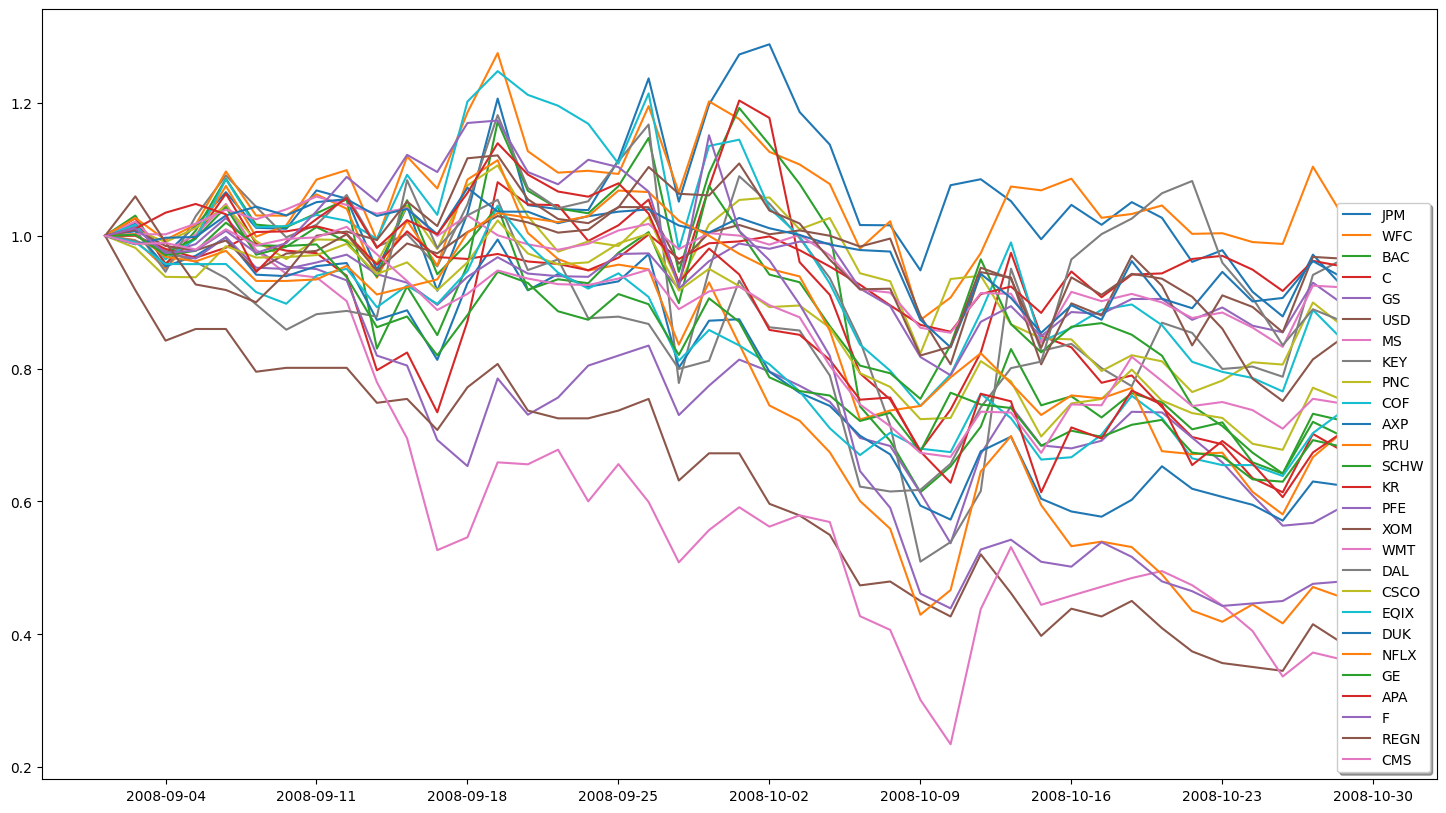

In [ ]:
plt.plot(YData0_dates, YData0  / YData0 [0, :])  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='medium')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.show()

# Step 4 Correlation Matrix

In [ ]:
def PlotCorrelations(log_returns, CORR_FILTER):
    print(f"{len(ALL)}x{len(ALL)} correlation matrix is:")
    print(log_returns.corr())
    plt.figure(figsize=(18,18))
    plt.title(f"Cross Correlations of Assets")
    print(f"{len(ALL)}x{len(ALL)} correlation heatmap is:")
    sns.heatmap(log_returns.corr(),linecolor='white',linewidths=1,annot=True)
    plt.savefig(f"Chart_01_Correlation.jpg", format='jpg', dpi=300)
    plt.show()

    plt.figure(figsize=(18,18))
    mask = np.triu(np.ones_like(log_returns.corr()))
    heatmap = sns.heatmap(log_returns.corr(),mask=mask, vmin=-1,vmax=1,cmap='coolwarm', annot=True)
    heatmap.set_title('Correlation heatmap', fontdict={'fontsize':12},pad=12);
    plt.savefig(f"Chart_02_TriangularCorrelation.jpg", format='jpg', dpi=300)
    plt.show()

    plt.figure(figsize=(18,18))
    c = log_returns.corr()
    heatmap = sns.heatmap((c >= CORR_FILTER) ,linecolor='white', cmap='coolwarm', linewidths=1,annot = True)
    heatmap.set_title(f'Selective Correlation heatmap with Correlation > {CORR_FILTER}', fontdict={'fontsize':12},pad=12);
    plt.savefig(f"Chart_03_Selective Correlation.jpg", format='jpg', dpi=300)
    plt.show()


    plt.figure(figsize=(18,18))
    heatmap = sns.clustermap(log_returns.corr(),row_cluster=True, vmin=-1,vmax=1,cmap='coolwarm', annot=True)
    #sns.clustermap(log_returns.corr,row_cluster=True, metric="correlation")
    plt.savefig(f"Chart_04_ClusterCorrelation.", format='jpg', dpi=300)
    plt.show()

    plt.figure(figsize=(18,18))
    sns.heatmap(log_returns.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
    plt.savefig(f"Chart_05_ClusterCorrelationV2.", format='jpg', dpi=300)
    plt.show()

27x27 correlation matrix is:
           JPM       WFC       BAC         C        GS       USD        MS  \
JPM   1.000000  0.790343  0.835627  0.802532  0.480871  0.648163  0.370179   
WFC   0.790343  1.000000  0.821162  0.730172  0.519931  0.607104  0.471911   
BAC   0.835627  0.821162  1.000000  0.886437  0.657263  0.620690  0.595503   
C     0.802532  0.730172  0.886437  1.000000  0.620249  0.571237  0.588370   
GS    0.480871  0.519931  0.657263  0.620249  1.000000  0.489529  0.820379   
USD   0.648163  0.607104  0.620690  0.571237  0.489529  1.000000  0.601798   
MS    0.370179  0.471911  0.595503  0.588370  0.820379  0.601798  1.000000   
KEY   0.565309  0.715325  0.748191  0.729861  0.608527  0.423321  0.584865   
PNC   0.829903  0.750791  0.655586  0.621801  0.217004  0.595953  0.218950   
COF   0.720218  0.786556  0.786845  0.783660  0.497911  0.709807  0.518227   
AXP   0.691738  0.750286  0.760773  0.748823  0.700214  0.752037  0.725148   
PRU   0.493723  0.719225  0.620612 

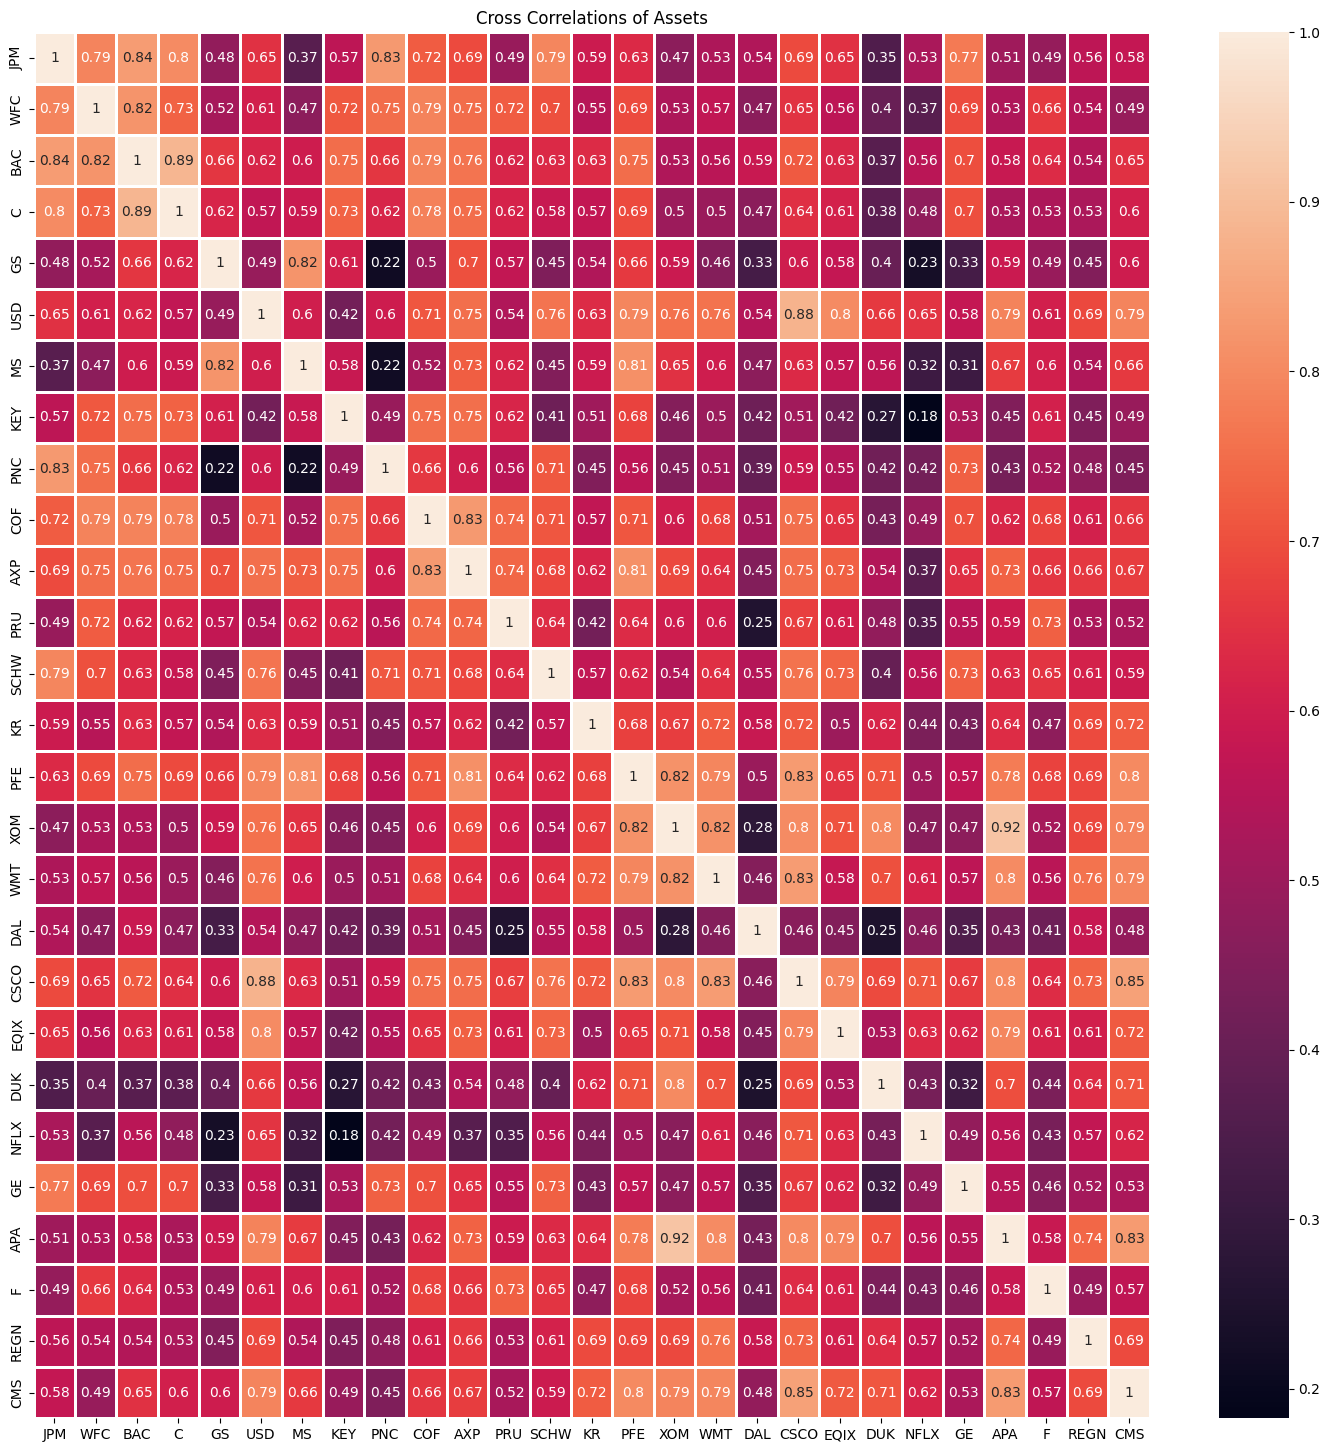

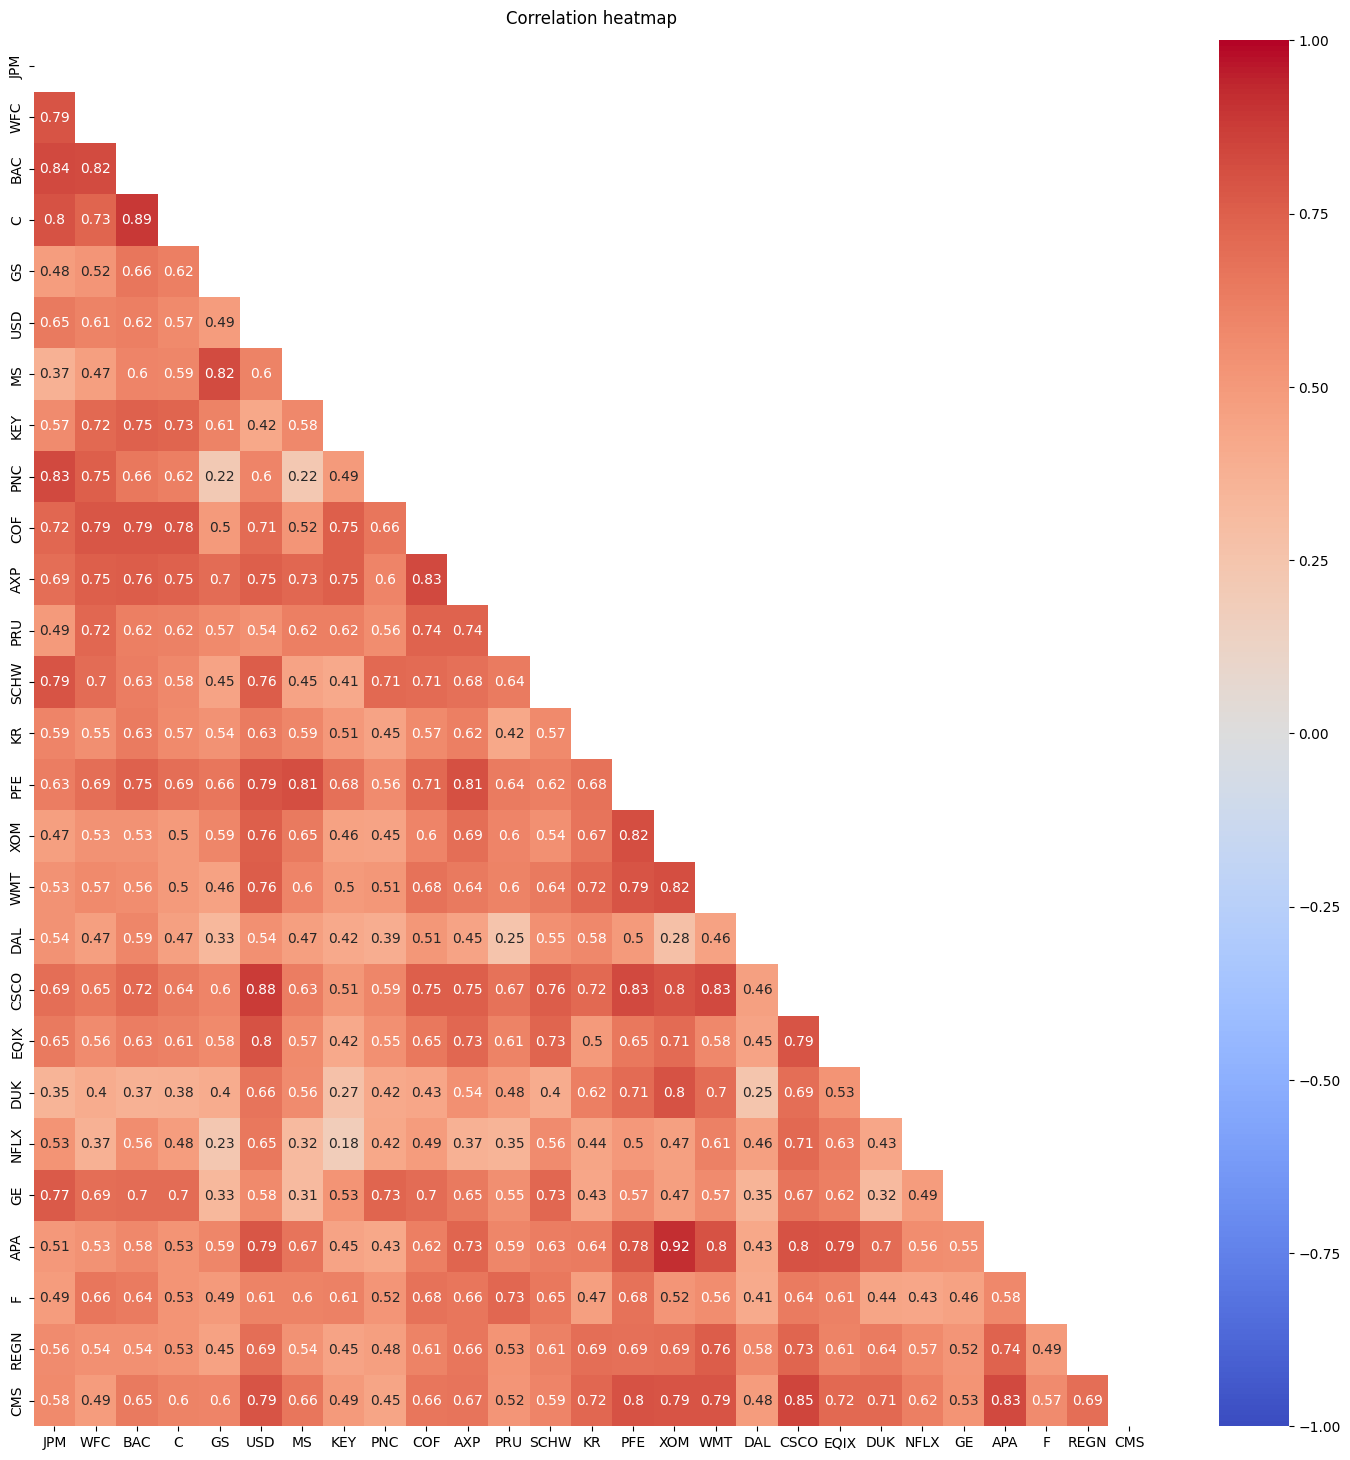

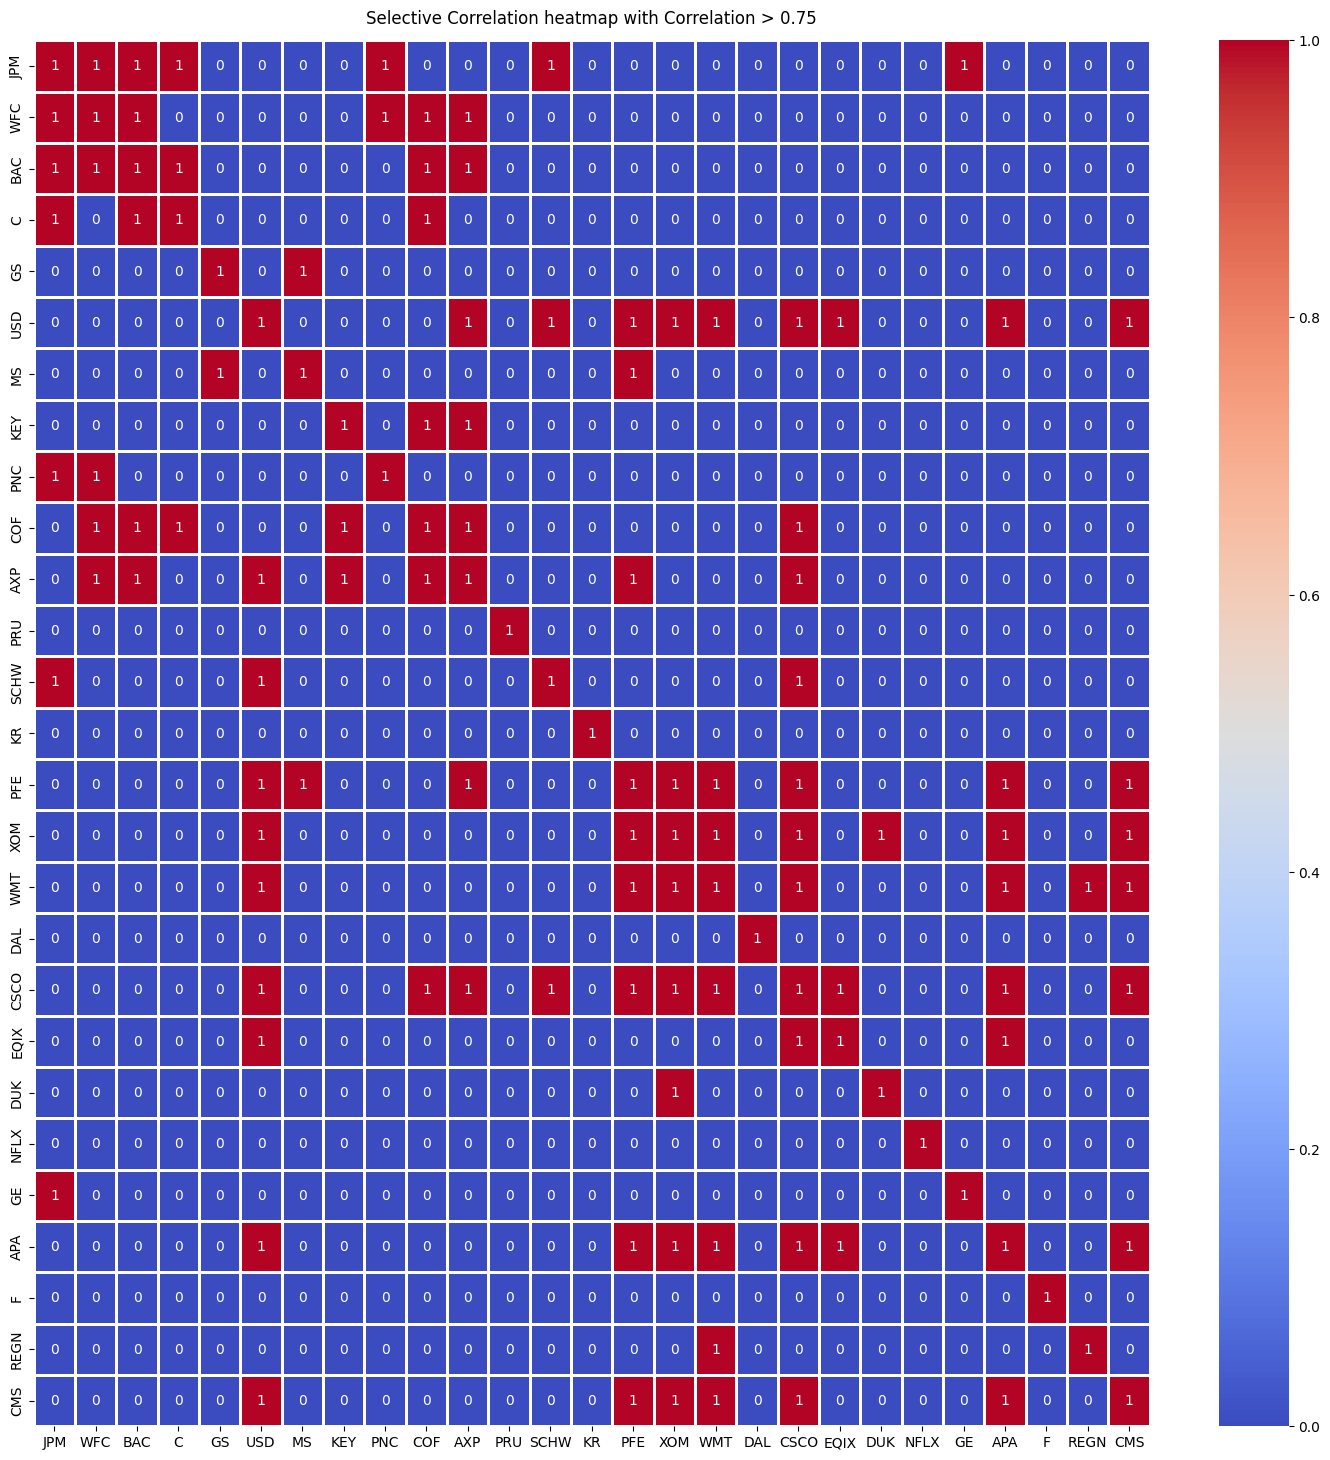

<Figure size 1800x1800 with 0 Axes>

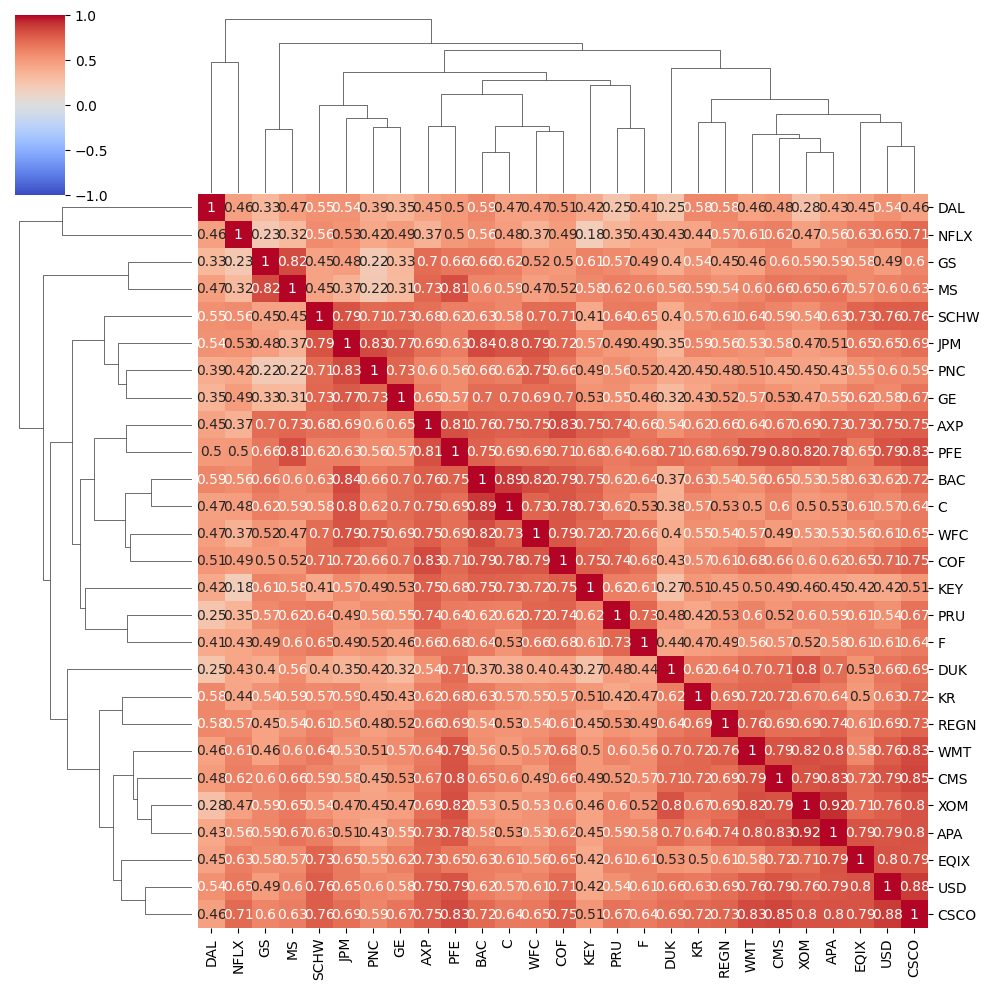

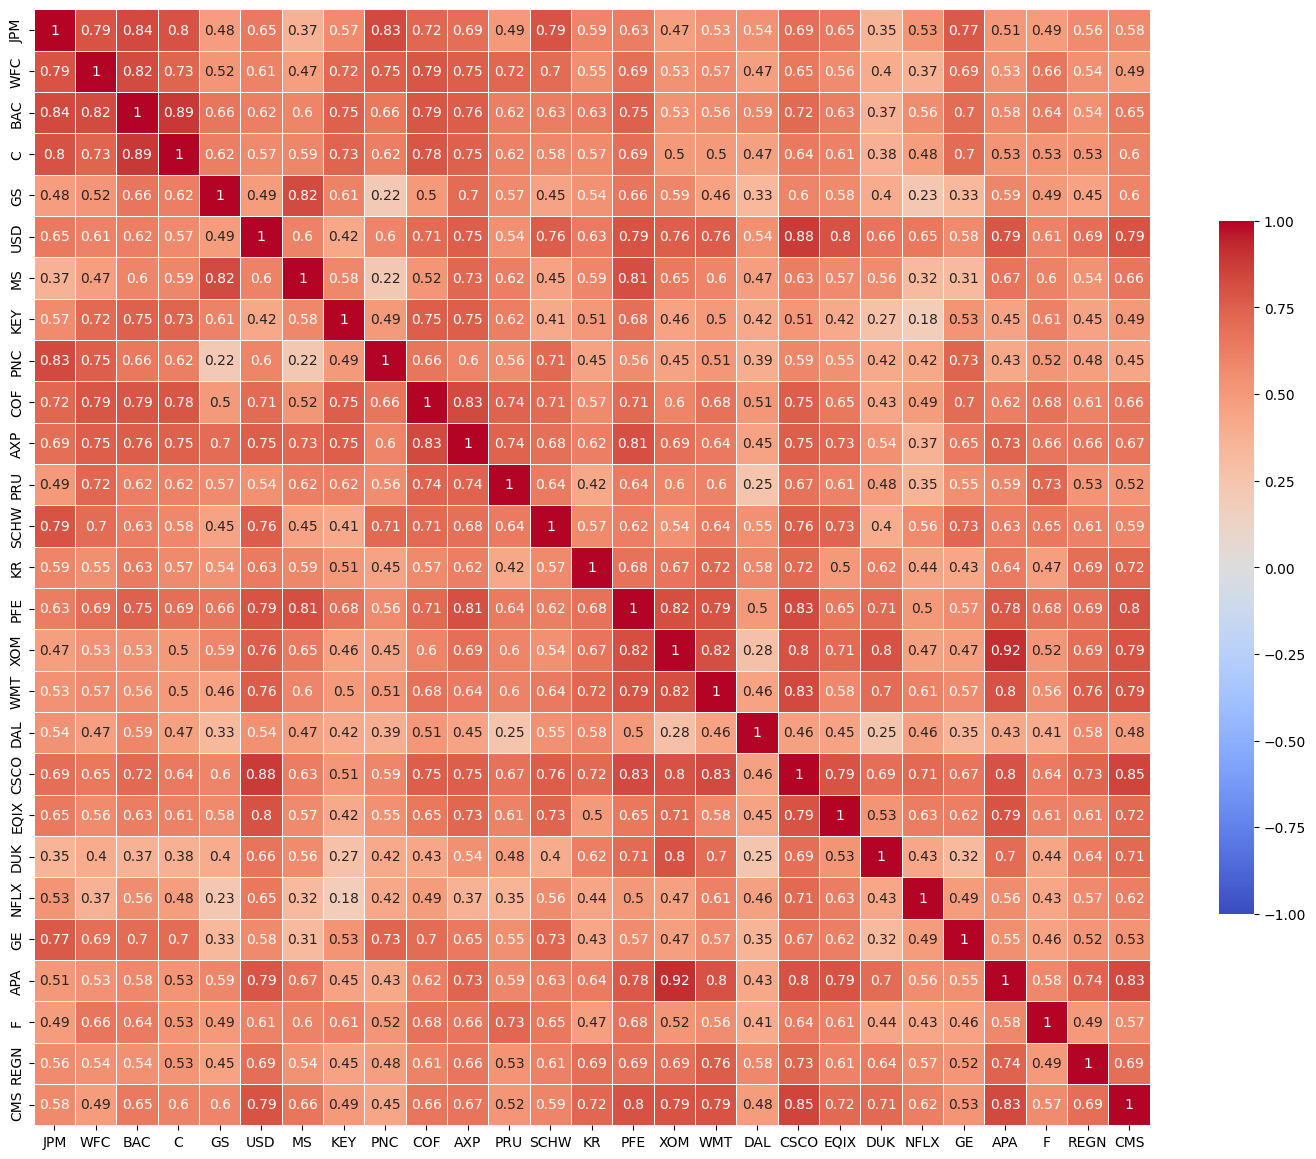

In [ ]:

PlotCorrelations(Returns0, CORR_FILTER= 0.75)

# Step 6 Upper-Confidence Bound (UBC) algorithm

In [ ]:
def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new


In [ ]:
# Bandit problem for stock selection

NK = len(ALL)
EPSILON = 0.1
ALPHA = 0.875
NEPISODES = 1000
HOLD = 1
TMAX = YData0.shape[0] - HOLD
UCB_weight = 1.5

seed(1234)


reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))
reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            YData0[tt + HOLD, aa_opt] - YData0[tt, aa_opt]
        ) / YData0[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + UCB_weight * np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((YData0[tt + HOLD, :] - YData0[tt, :]) / YData0[tt, :])
        ) / NEPISODES  # noQA E203

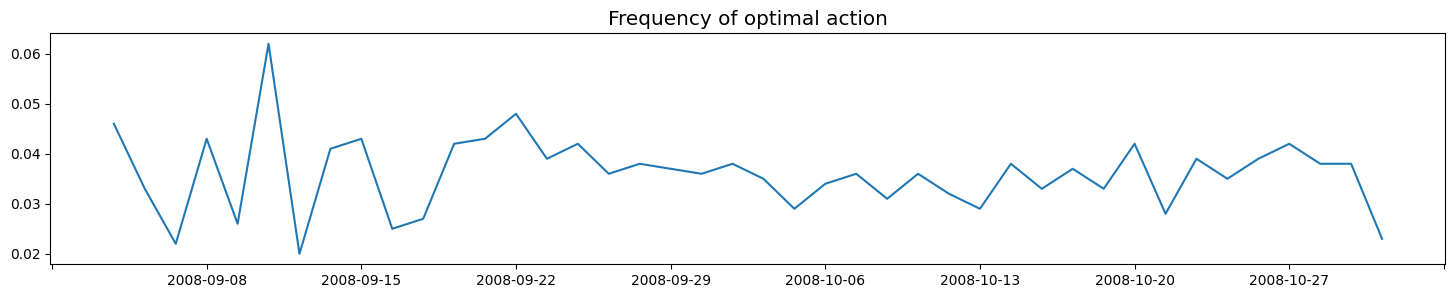

In [ ]:
plt.plot(YData0_dates[HOLD : YData0.shape[0]], optimal_avg)  # noQA E203
plt.title("Frequency of optimal action", fontsize="x-large")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

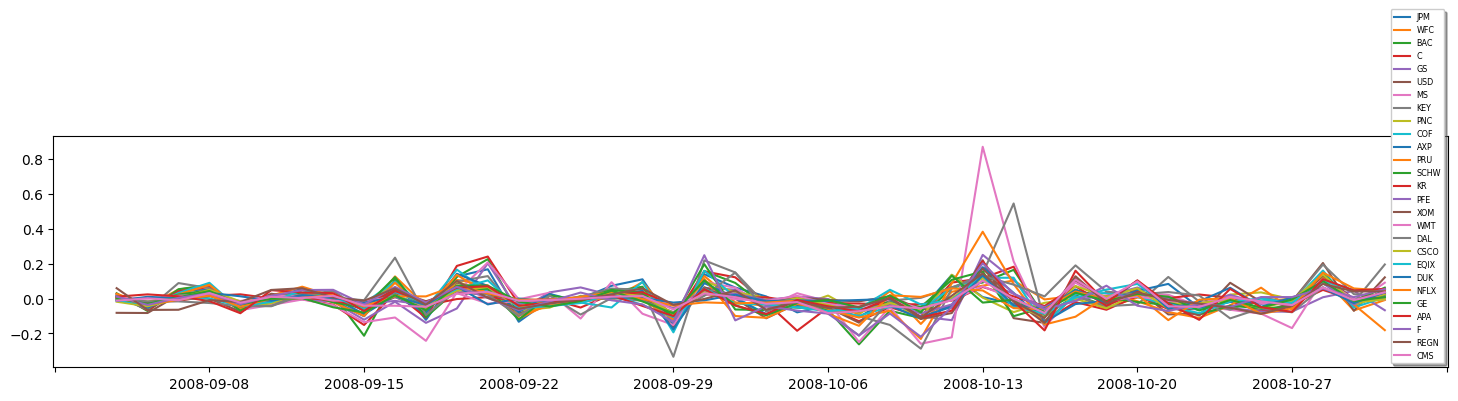

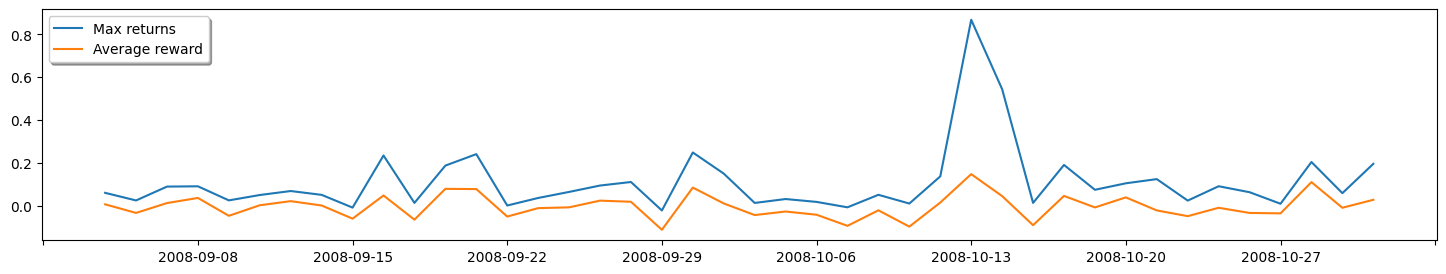

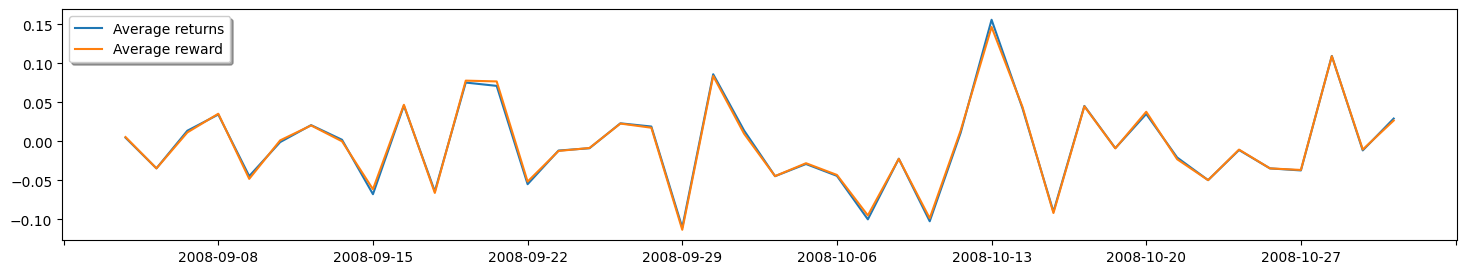

0.036
-0.6263 0.8868
-0.6138 0.8756


In [ ]:
plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :],
)  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='xx-small')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    np.max(
        (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD : YData0.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    np.mean(
        (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD : YData0.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(round(np.mean(optimal_avg),4))
# Average annualized return from holding the equally-weighted portfolio
print(round(
    (
        1
        + np.mean(
            (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,4),round(
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :],
            axis=1,
        )
    ),4)
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    round((1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,4),
    round(np.sqrt(250 / HOLD) * np.std(reward_avg),4),
)

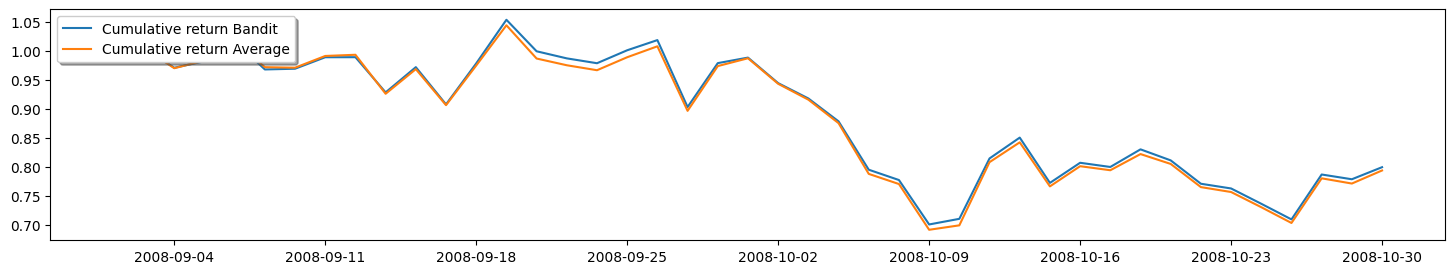

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData0[tt + HOLD - 1, :] - YData0[tt - 1, :]) / YData0[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData0_dates[HOLD - 1 : YData0.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD - 1 : YData0.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Step 8 Epsilon-greedy algorithm.

In [ ]:
# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = len(ALL)
epsilon = 0.1
ALPHA = 0.875
HOLD = 1
TMAX = YData0.shape[0] - HOLD
NEPISODES = 1000

seed(1234)


In [ ]:
reward_avg = np.zeros((TMAX, 1))
optimal_avg = np.zeros((TMAX, 1))
for run in range(NEPISODES):
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    nchoices = np.zeros((NK))
    for tt in range(TMAX):
        aa_opt = optimal_action(qvalue, epsilon)
        reward = (YData0[tt + HOLD, aa_opt] - YData0[tt, aa_opt]) / YData0[tt, aa_opt]
        nchoices[aa_opt] += 1  # update with avg. number of times aa_opt was chosen
        qvalue = reward_update(aa_opt, reward, qvalue, ALPHA) #1 / nchoices[aa_opt]
        reward_avg[tt] += reward / NEPISODES
        optimal_avg[tt] += (aa_opt == np.argmax((YData0[tt + HOLD, :] - YData0[tt, :]) / YData0[tt, :])) / NEPISODES

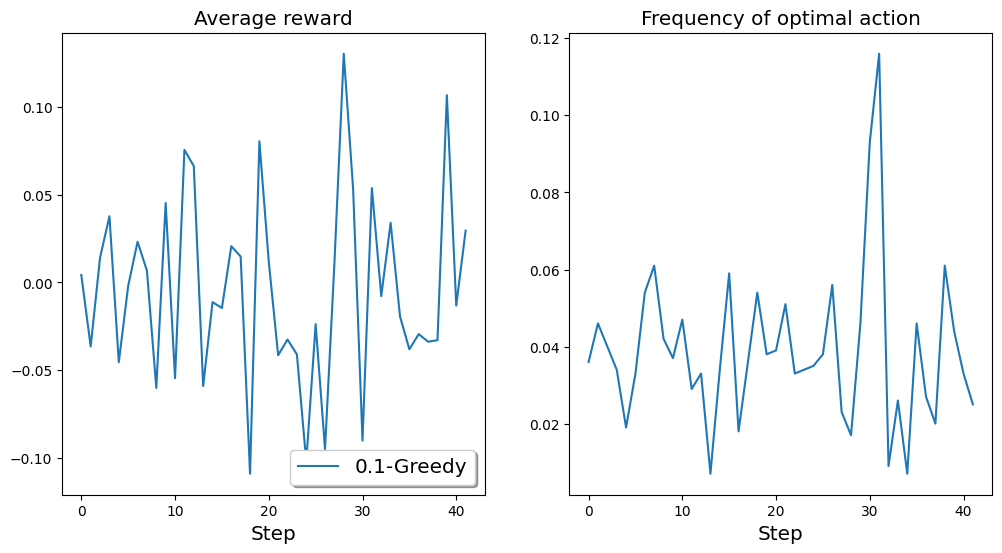

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg, label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg, label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

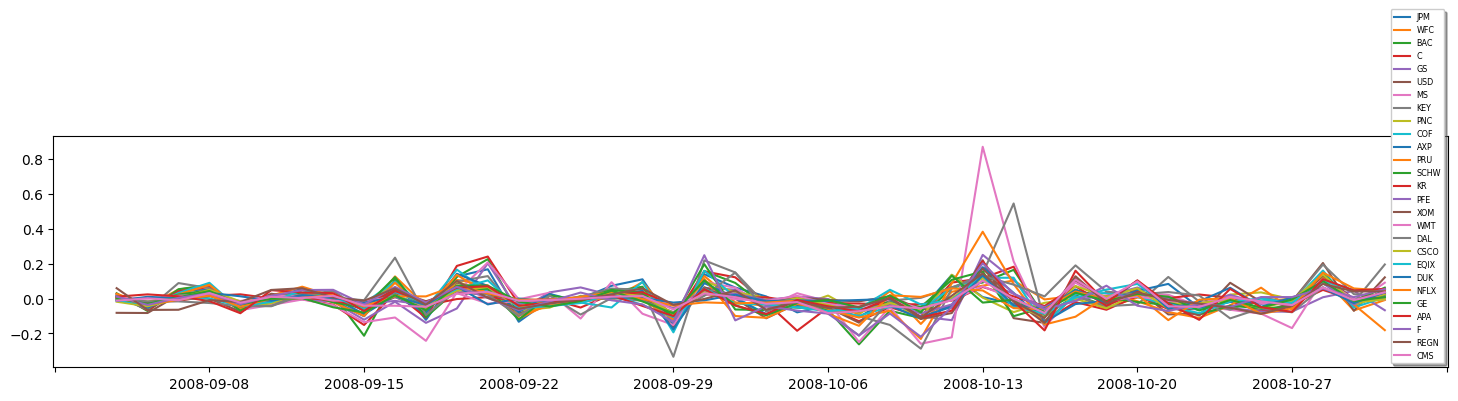

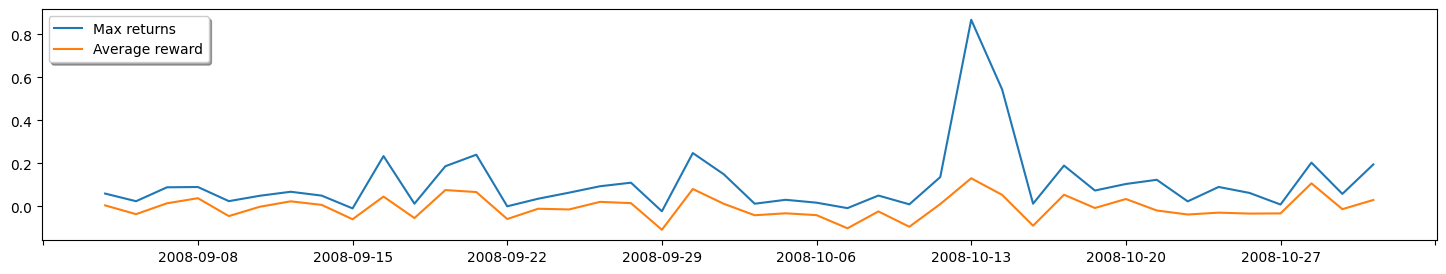

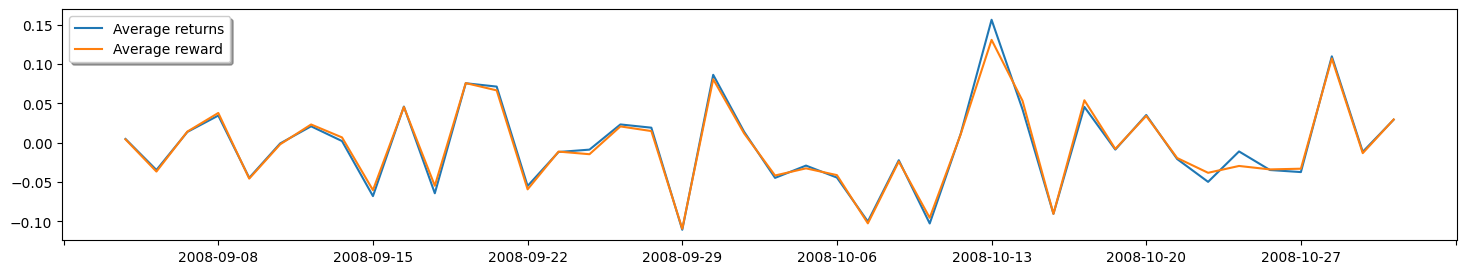

0.039
-0.6263 0.8868
-0.6491 0.8489


In [ ]:

plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :],
)  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='xx-small')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    np.max(
        (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD : YData0.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData0_dates[HOLD : YData0.shape[0]],
    np.mean(
        (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD : YData0.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(round(np.mean(optimal_avg),4))
# Average annualized return from holding the equally-weighted portfolio
print(round(
    (
        1
        + np.mean(
            (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,4),round(
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData0[HOLD : YData0.shape[0], :] - YData0[0:TMAX, :]) / YData0[0:TMAX, :],
            axis=1,
        )
    ),4)
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    round((1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,4),
    round(np.sqrt(250 / HOLD) * np.std(reward_avg),4),
)

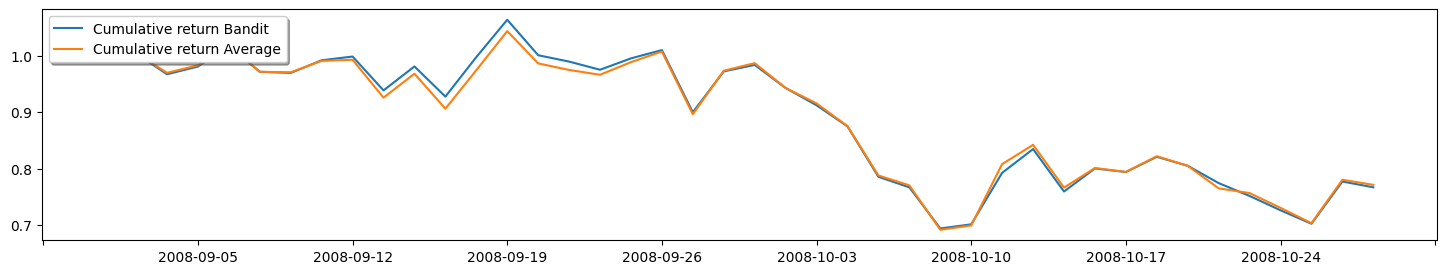

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData0[tt + HOLD - 1, :] - YData0[tt - 1, :]) / YData0[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData0_dates[HOLD - 1 : YData0.shape[0]-HOLD],
    return_cumulative[:-HOLD, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData0_dates[HOLD - 1 : YData0.shape[0]-HOLD],
    return_cumulative[:-HOLD, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Step 10 Import and Structure Data for 2020

In [ ]:
Prices1, Returns1 = DownloadAssetsConvertDataframe(ALL, T1_START, T1_END)
YData1 = Prices1.to_numpy()
YData1_dates = Prices1.index

Comparing assets for Sharpe and Std Dev


In [ ]:
Prices1

JPM    WFC    BAC      C      GS    USD     MS    KEY     PNC  \
2020-01-02  125.94  48.73  32.80  70.53  215.88  15.94  46.45  17.29  140.33   
2020-01-03  124.28  48.43  32.12  69.20  213.36  15.43  45.70  16.99  138.98   
2020-01-06  124.18  48.14  32.08  68.98  215.54  15.19  45.54  16.73  138.70   
2020-01-07  122.07  47.74  31.86  68.38  216.96  15.55  45.45  16.61  137.60   
2020-01-08  123.02  47.88  32.19  68.90  219.05  15.54  46.03  16.77  139.03   
...            ...    ...    ...    ...     ...    ...    ...    ...     ...   
2020-12-23  115.70  28.62  28.40  54.90  241.96  24.63  62.71  14.70  133.70   
2020-12-24  115.19  28.14  28.31  54.71  241.69  24.90  62.60  14.57  133.20   
2020-12-28  115.95  28.22  28.47  55.22  244.92  24.83  62.57  14.62  133.56   
2020-12-29  115.64  28.08  28.36  55.02  243.43  24.81  62.25  14.37  132.04   
2020-12-30  115.97  28.05  28.33  54.97  244.79  25.55  62.37  14.62  133.88   

              COF  ...    DAL   CSCO    EQIX    DUK    NFLX     GE    APA  \
2020-01-02  96.77  ...  58.51  43.41  546.46  78.50  329.81  73.46  23.97   
2020-01-03  95.27  ...  57.54  42.70  551.90  78.55  325.90  73.70  24.28   
2020-01-06  94.41  ...  57.14  42.85  551.30  78.94  335.83  74.75  24.23   
2020-01-07  93.47  ...  57.09  42.57  548.85  78.44  330.75  74.19  30.72   
2020-01-08  94.46  ...  58.32  42.60  550.66  78.55  339.26  73.52  30.93   
...           ...  ...    ...    ...     ...    ...     ...    ...    ...   
2020-12-23  91.64  ...  40.16  40.85  673.28  80.75  514.48  67.21  14.18   
2020-12-24  92.10  ...  39.65  41.00  676.02  81.33  513.97  65.91  13.84   
2020-12-28  92.33  ...  40.07  41.35  679.79  81.85  519.12  65.85  13.63   
2020-12-29  91.04  ...  39.95  41.09  678.74  81.50  530.87  65.35  13.57   
2020-12-30  92.64  ...  40.47  40.95  670.72  82.13  524.59  66.28  13.98   

               F    REGN    CMS  
2020-01-02  8.20  373.35  55.40  
2020-01-03  8.02  369.16  55.94  
2020-01-06  7.98  371.74  56.19  
2020-01-07  8.05  373.13  55.90  
2020-01-08  8.05  382.42  55.89  
...          ...     ...    ...  
2020-12-23  7.96  492.19  53.11  
2020-12-24  7.85  488.93  53.61  
2020-12-28  7.87  482.96  54.22  
2020-12-29  7.81  484.22  54.53  
2020-12-30  7.85  478.30  55.23  

[252 rows x 27 columns]

In [ ]:
np.round(Returns1,4)

JPM     WFC     BAC       C      GS     USD      MS     KEY  \
2020-01-03 -0.0133 -0.0062 -0.0209 -0.0190 -0.0117 -0.0325 -0.0163 -0.0175   
2020-01-06 -0.0008 -0.0060 -0.0012 -0.0032  0.0102 -0.0157 -0.0035 -0.0154   
2020-01-07 -0.0171 -0.0083 -0.0069 -0.0087  0.0066  0.0234 -0.0020 -0.0072   
2020-01-08  0.0078  0.0029  0.0103  0.0076  0.0096 -0.0006  0.0127  0.0096   
2020-01-09  0.0037 -0.0017  0.0016  0.0091  0.0202  0.0115  0.0095  0.0018   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2020-12-23  0.0276  0.0469  0.0282  0.0253  0.0251 -0.0169  0.0232  0.0374   
2020-12-24 -0.0044 -0.0169 -0.0032 -0.0035 -0.0011  0.0109 -0.0018 -0.0089   
2020-12-28  0.0066  0.0028  0.0056  0.0093  0.0133 -0.0028 -0.0005  0.0034   
2020-12-29 -0.0027 -0.0050 -0.0039 -0.0036 -0.0061 -0.0008 -0.0051 -0.0172   
2020-12-30  0.0028 -0.0011 -0.0011 -0.0009  0.0056  0.0294  0.0019  0.0172   

               PNC     COF  ...     DAL    CSCO    EQIX     DUK    NFLX  \
2020-01-03 -0.0097 -0.0156  ... -0.0167 -0.0165  0.0099  0.0006 -0.0119   
2020-01-06 -0.0020 -0.0091  ... -0.0070  0.0035 -0.0011  0.0050  0.0300   
2020-01-07 -0.0080 -0.0100  ... -0.0009 -0.0066 -0.0045 -0.0064 -0.0152   
2020-01-08  0.0103  0.0105  ...  0.0213  0.0007  0.0033  0.0014  0.0254   
2020-01-09  0.0120  0.0135  ...  0.0019 -0.0042  0.0088  0.0025 -0.0107   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2020-12-23  0.0204  0.0191  ...  0.0329 -0.0071 -0.0146 -0.0056 -0.0247   
2020-12-24 -0.0037  0.0050  ... -0.0128  0.0037  0.0041  0.0072 -0.0010   
2020-12-28  0.0027  0.0025  ...  0.0105  0.0085  0.0056  0.0064  0.0100   
2020-12-29 -0.0114 -0.0141  ... -0.0030 -0.0063 -0.0015 -0.0043  0.0224   
2020-12-30  0.0138  0.0174  ...  0.0129 -0.0034 -0.0119  0.0077 -0.0119   

                GE     APA       F    REGN     CMS  
2020-01-03  0.0033  0.0128 -0.0222 -0.0113  0.0097  
2020-01-06  0.0141 -0.0021 -0.0050  0.0070  0.0045  
2020-01-07 -0.0075  0.2373  0.0087  0.0037 -0.0052  
2020-01-08 -0.0091  0.0068  0.0000  0.0246 -0.0002  
2020-01-09 -0.0026 -0.0039  0.0012  0.0027  0.0077  
...            ...     ...     ...     ...     ...  
2020-12-23  0.0233  0.0454  0.0229  0.0043  0.0002  
2020-12-24 -0.0195 -0.0243 -0.0139 -0.0066  0.0094  
2020-12-28 -0.0009 -0.0153  0.0025 -0.0123  0.0113  
2020-12-29 -0.0076 -0.0044 -0.0077  0.0026  0.0057  
2020-12-30  0.0141  0.0298  0.0051 -0.0123  0.0128  

[251 rows x 27 columns]

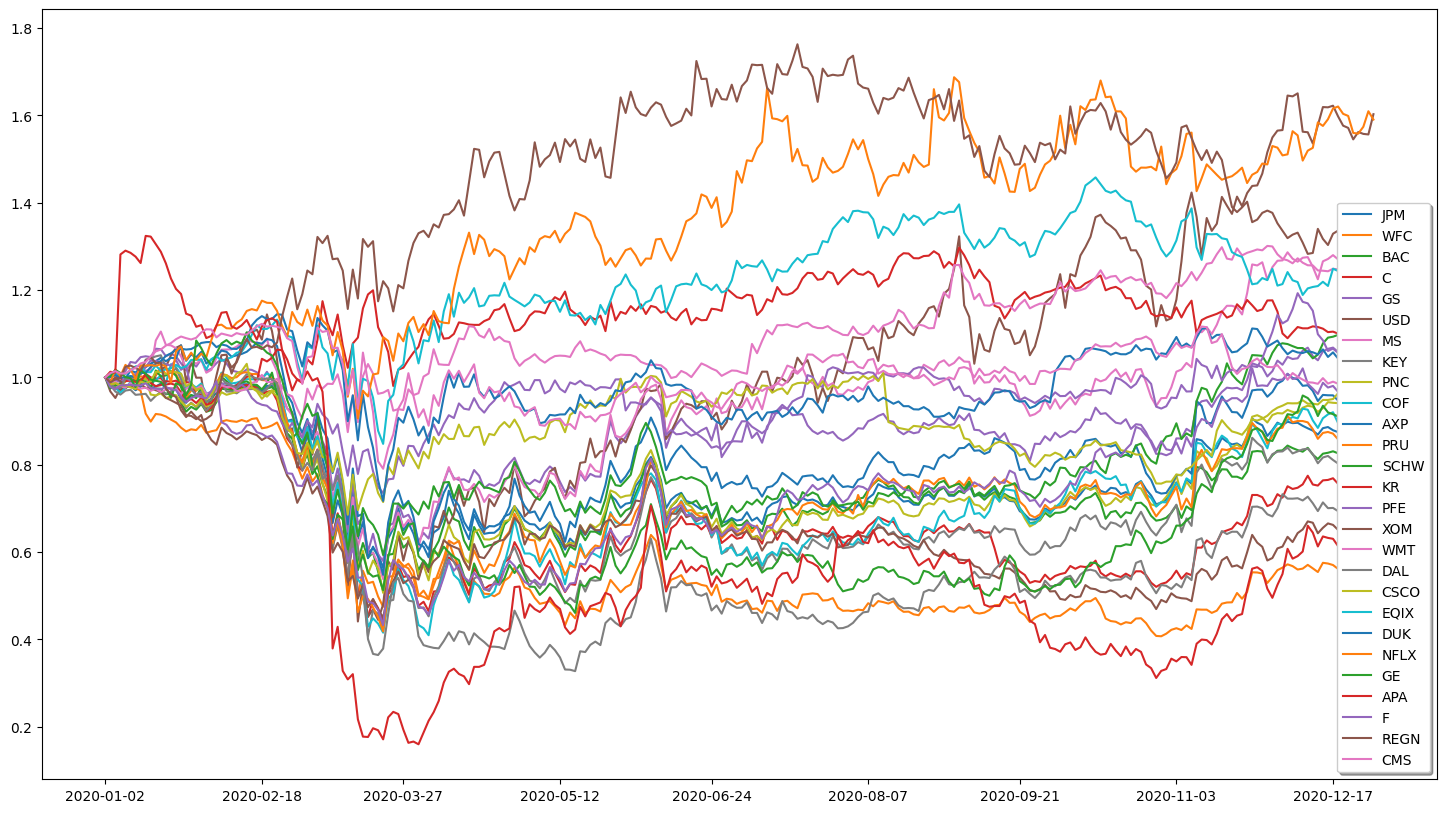

In [ ]:
plt.plot(YData1_dates, YData1  / YData1 [0, :])  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='medium')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.show()

# Step 11 Rerun algorithm for new data (2020)

In [ ]:
# Bandit problem for stock selection

#Slightly change the paramter
NK = len(ALL)
EPSILON = 0.15
ALPHA = 0.8
NEPISODES = 1000
HOLD = 2
TMAX = YData1.shape[0] - HOLD
UCB_weight = 2

seed(1234)


reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))
reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            YData1[tt + HOLD, aa_opt] - YData1[tt, aa_opt]
        ) / YData1[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + UCB_weight * np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((YData1[tt + HOLD, :] - YData1[tt, :]) / YData1[tt, :])
        ) / NEPISODES  # noQA E203

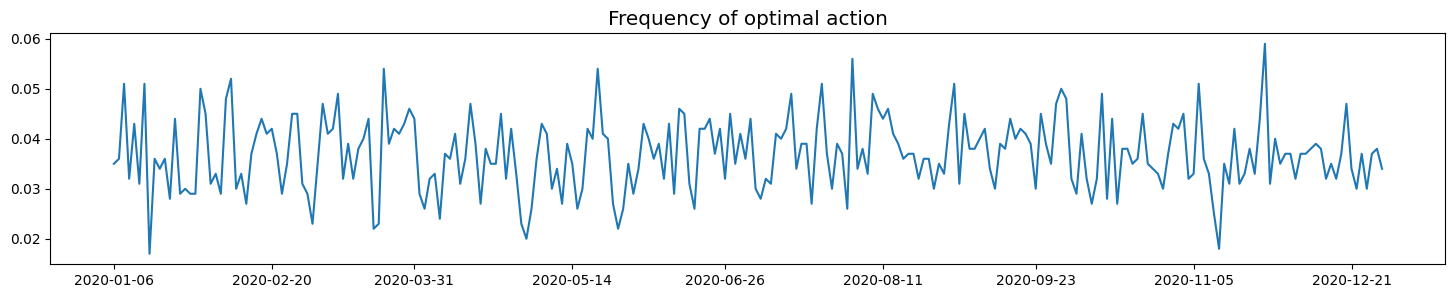

In [ ]:
plt.plot(YData1_dates[HOLD : YData1.shape[0]], optimal_avg)  # noQA E203
plt.title("Frequency of optimal action", fontsize="x-large")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

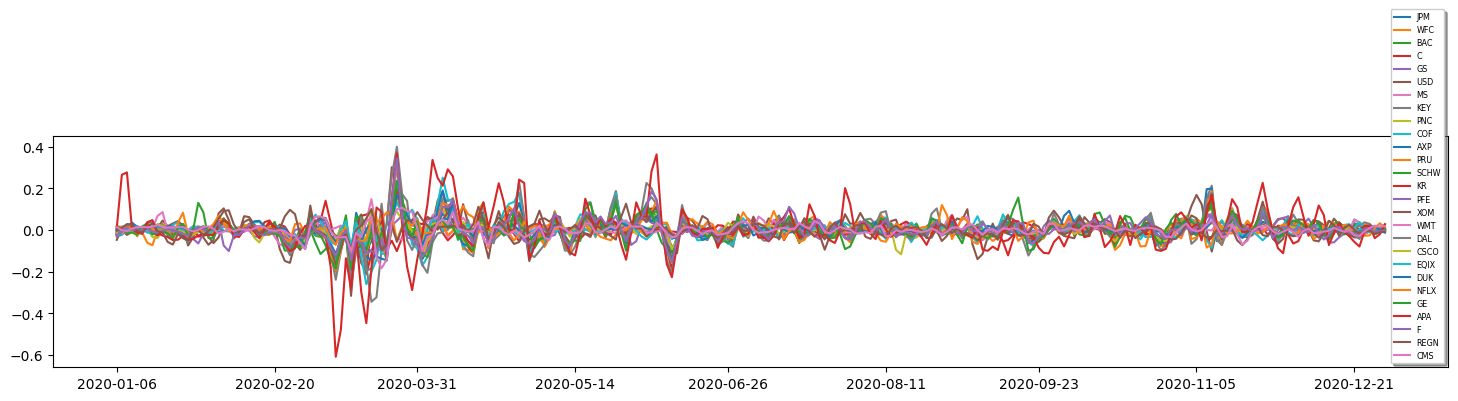

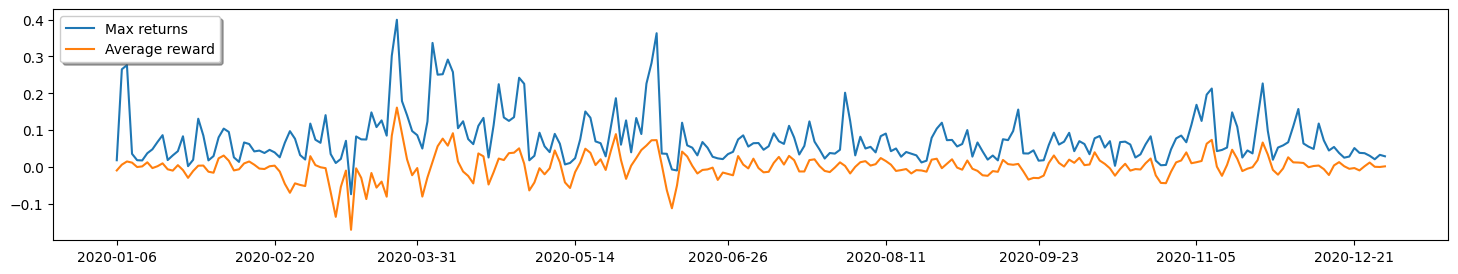

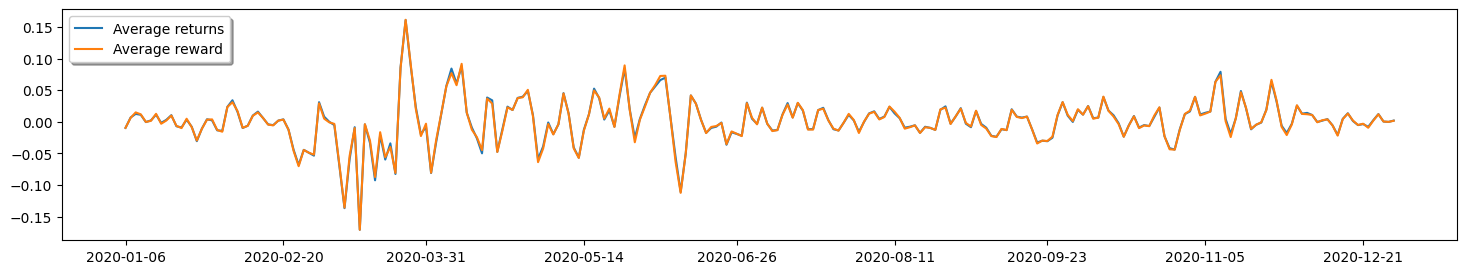

0.0369
0.1515 0.3865
0.125 0.3871


In [ ]:
plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :],
)  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='xx-small')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    np.max(
        (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD : YData1.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    np.mean(
        (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD : YData1.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(round(np.mean(optimal_avg),4))
# Average annualized return from holding the equally-weighted portfolio
print(round(
    (
        1
        + np.mean(
            (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,4),round(
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :],
            axis=1,
        )
    ),4)
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    round((1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,4),
    round(np.sqrt(250 / HOLD) * np.std(reward_avg),4),
)

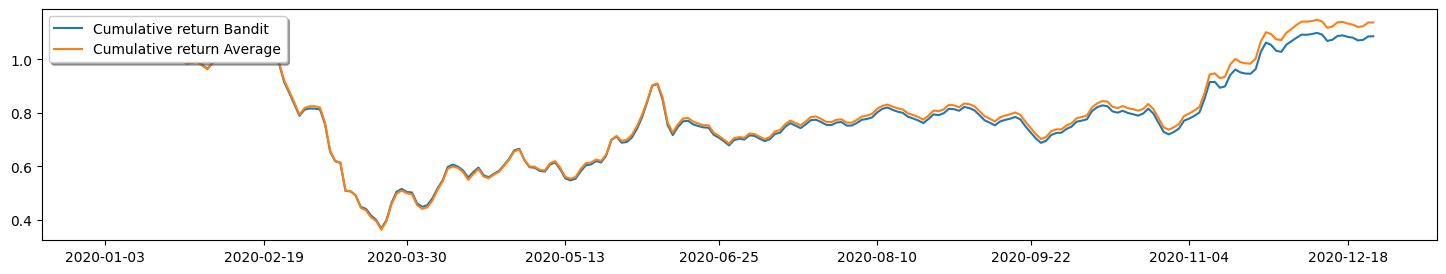

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData1[tt + HOLD - 1, :] - YData1[tt - 1, :]) / YData1[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData1_dates[HOLD - 1 : YData1.shape[0]-HOLD],
    return_cumulative[:-HOLD, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD - 1 : YData1.shape[0]-HOLD],
    return_cumulative[:-HOLD, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

In [ ]:
# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = len(ALL)
epsilon = 0.15
ALPHA = 0.8
HOLD = 2
TMAX = YData1.shape[0] - HOLD
NEPISODES = 1000

seed(1234)


In [ ]:
reward_avg = np.zeros((TMAX, 1))
optimal_avg = np.zeros((TMAX, 1))
for run in range(NEPISODES):
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    nchoices = np.zeros((NK))
    for tt in range(TMAX):
        aa_opt = optimal_action(qvalue, epsilon)
        reward = (YData1[tt + HOLD, aa_opt] - YData1[tt, aa_opt]) / YData1[tt, aa_opt]
        nchoices[aa_opt] += 1  # update with avg. number of times aa_opt was chosen
        qvalue = reward_update(aa_opt, reward, qvalue, ALPHA) #1 / nchoices[aa_opt]
        reward_avg[tt] += reward / NEPISODES
        optimal_avg[tt] += (aa_opt == np.argmax((YData1[tt + HOLD, :] - YData1[tt, :]) / YData1[tt, :])) / NEPISODES

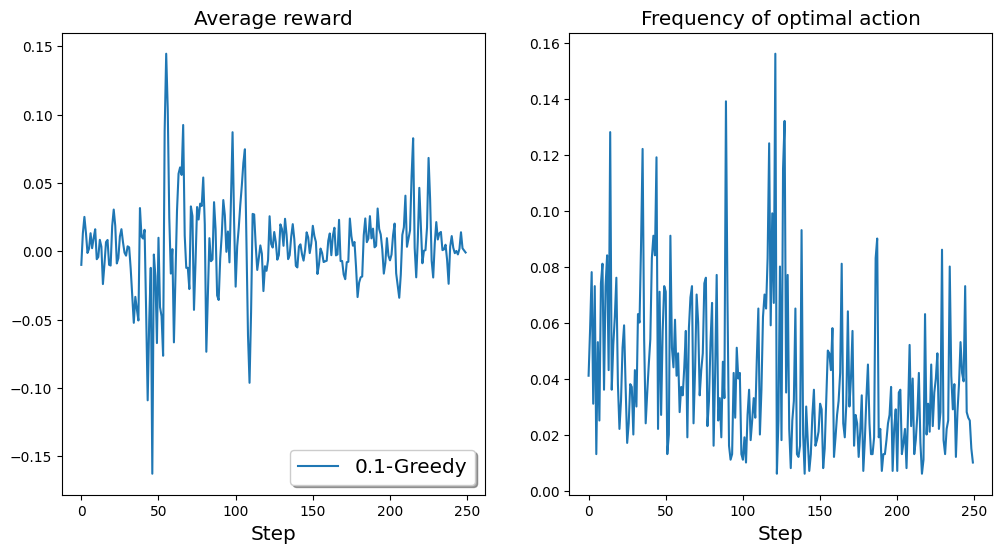

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg, label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg, label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

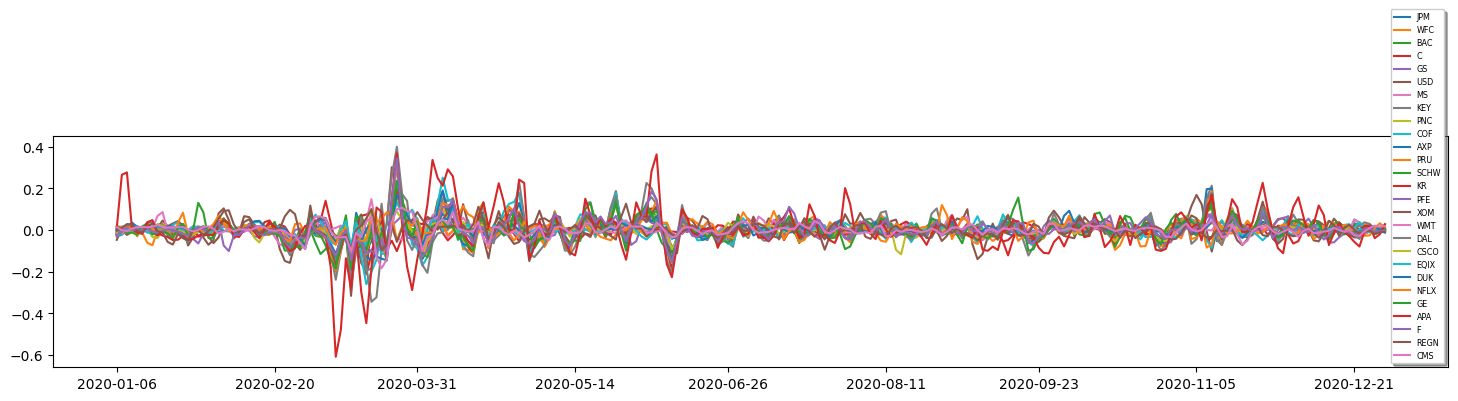

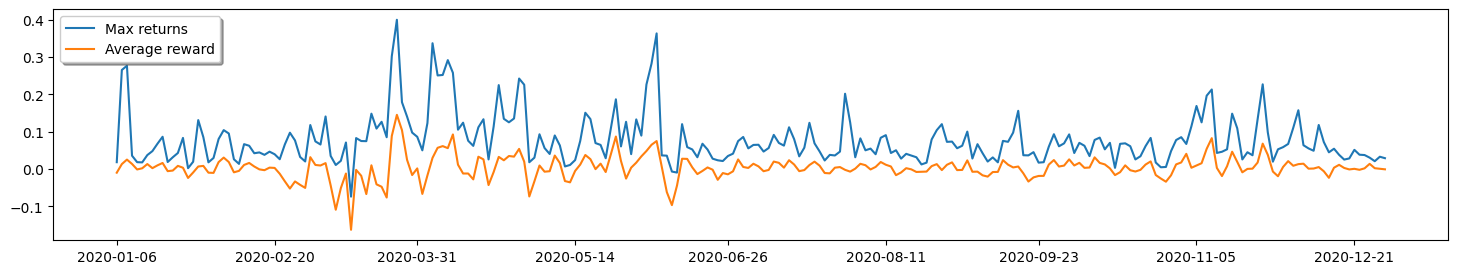

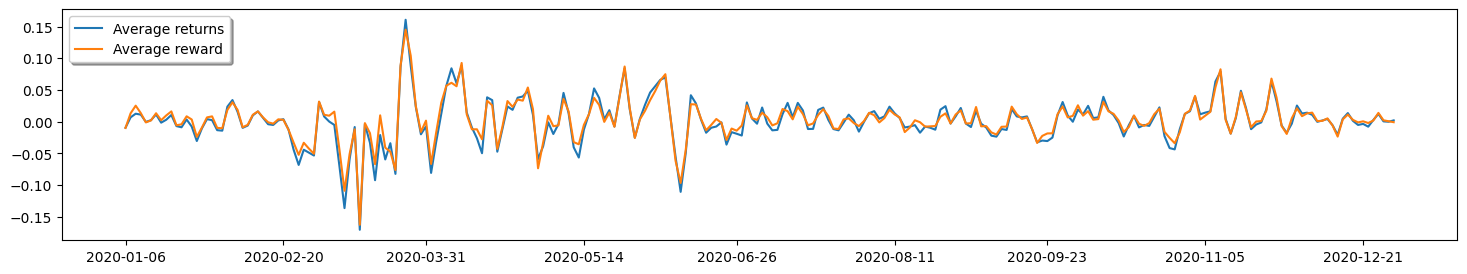

0.0407
0.1515 0.3865
0.5007 0.349


In [ ]:

plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :],
)  # noQA E203
plt.legend(ALL,loc='lower right', shadow=True,fontsize='xx-small')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    np.max(
        (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD : YData1.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData1_dates[HOLD : YData1.shape[0]],
    np.mean(
        (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD : YData1.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(round(np.mean(optimal_avg),4))
# Average annualized return from holding the equally-weighted portfolio
print(round(
    (
        1
        + np.mean(
            (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,4),round(
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData1[HOLD : YData1.shape[0], :] - YData1[0:TMAX, :]) / YData1[0:TMAX, :],
            axis=1,
        )
    ),4)
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    round((1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,4),
    round(np.sqrt(250 / HOLD) * np.std(reward_avg),4),
)

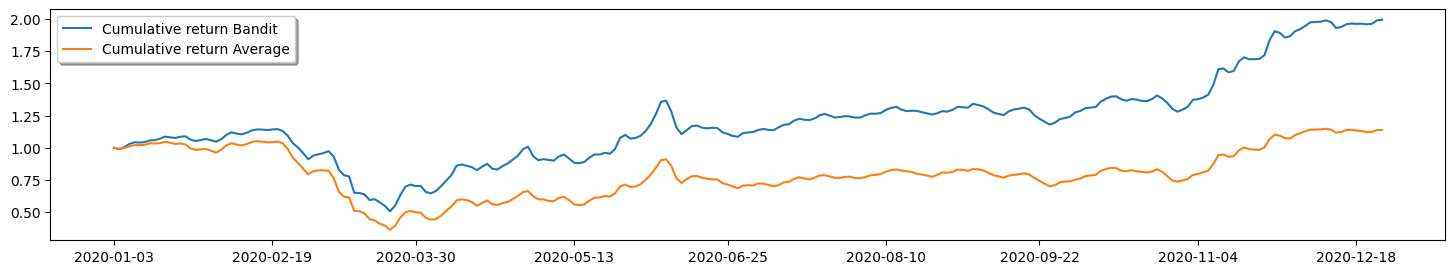

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData1[tt + HOLD - 1, :] - YData1[tt - 1, :]) / YData1[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData1_dates[HOLD - 1 : YData1.shape[0]-HOLD],
    return_cumulative[:-HOLD, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData1_dates[HOLD - 1 : YData1.shape[0]-HOLD],
    return_cumulative[:-HOLD, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()